In [1]:
# Importing Necessary Libraries
import wandb  # For experiment tracking
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.applications import VGG16  # Pre-trained model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input  # Model layers
from tensorflow.keras.models import Model  # Model architecture
from tensorflow.keras.optimizers import Adam  # Optimization algorithm
from tensorflow.keras.utils import to_categorical  # For one-hot encoding
from sklearn.preprocessing import LabelBinarizer  # For label encoding
from sklearn.model_selection import train_test_split  # For data splitting
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, auc, 
                           precision_score, recall_score, f1_score)  # Evaluation metrics
from imutils import paths  # For handling image paths
import matplotlib.pyplot as plt  # For visualizations
import numpy as np  # Numerical operations
import cv2  # Image processing
import os  # File system operations
import time  # For timing operations
from lime import lime_image  # For model interpretability
from skimage.segmentation import mark_boundaries  # For LIME visualizations
import tensorflow as tf  # Deep learning framework
import warnings  # For suppressing warnings

# Suppress warnings to clean up output
warnings.filterwarnings("ignore")

# Initialize Weights & Biases for experiment tracking
wandb.login(key="e8a360829806e69a22f56a7eb4c7b07aab8c6485")
run = wandb.init(project="final-project-new-ablations", name="amuhairw_final_project_run3")

# Configuration dictionary for model parameters
config = {
    'path_dir': "/kaggle/input/monkeypox-detection-dataset/converted_data",  # Dataset path
    'img_size': (224, 224),  # Input image size (matches VGG16 requirements)
    'batch_size': 30,  # Number of samples per gradient update
    'epochs': 100,  # Number of training epochs
    'learning_rate': 1e-3,  # Learning rate for optimizer
    'seed': 42  # Random seed for reproducibility
}

# Set random seeds for reproducibility
np.random.seed(config['seed'])
tf.random.set_seed(config['seed'])

2025-04-13 19:45:23.265734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744573523.288430    2853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744573523.295345    2853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amuhairw (delta-group-50) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-c

In [2]:
# =============================================
# DATA LOADING AND PREPROCESSING
# =============================================

print("[INFO] loading images...")
root_dir = config["path_dir"]
monkeypox_label = "Monkeypox_gray"
chickenpox_label = "Chickenpox_grayscale"
monkeypox_path = f"{root_dir}/{monkeypox_label}"
chickenpox_path = f"{root_dir}/{chickenpox_label}"

def load_images_from_folder(folder, label):
    """Load images from a specified folder and assign labels"""
    images = []
    labels_list = []
    if not os.path.exists(folder):
        print(f"Warning: {folder} directory does not exist")
        return images, labels_list

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                # Resize to match model input requirements
                image = cv2.resize(image, config['img_size'])
                images.append(image)
                labels_list.append(label)
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels_list

# Load images from both classes
chickenpox_images, chickenpox_labels = load_images_from_folder(chickenpox_path, chickenpox_label)
monkeypox_images, monkeypox_labels = load_images_from_folder(monkeypox_path, monkeypox_label)

# Combine and normalize data
data = np.array(chickenpox_images + monkeypox_images, dtype="float32") / 255.0  # Normalize to [0,1]
labels = np.array(chickenpox_labels + monkeypox_labels)

[INFO] loading images...
Loaded 47 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Chickenpox_grayscale
Loaded 43 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Monkeypox_gray


In [3]:
# =============================================
# TRAIN-TEST SPLIT
# =============================================

# Create train/test split with specific counts (34/9 for Monkeypox, 38/9 for Chickenpox)
class_data = {monkeypox_label: [], chickenpox_label: []}
for img, lbl in zip(data, labels):
    class_data[lbl].append(img)

trainX, testX, trainY, testY = [], [], [], []

# Monkeypox: 34 train, 9 test
monkey_images = class_data[monkeypox_label]
if len(monkey_images) >= 43:
    trainX.extend(monkey_images[:34])
    testX.extend(monkey_images[34:43])
    trainY.extend([monkeypox_label] * 34)
    testY.extend([monkeypox_label] * 9)
else:
    print(f"Warning: Not enough Monkeypox images. Found {len(monkey_images)}, need 43")

# Chickenpox: 38 train, 9 test
chicken_images = class_data[chickenpox_label]
if len(chicken_images) >= 47:
    trainX.extend(chicken_images[:38])
    testX.extend(chicken_images[38:47])
    trainY.extend([chickenpox_label] * 38)
    testY.extend([chickenpox_label] * 9)
else:
    print(f"Warning: Not enough Chickenpox images. Found {len(chicken_images)}, need 47")

# Convert to numpy arrays and one-hot encode labels
trainX, testX = np.array(trainX), np.array(testX)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
trainY = to_categorical(trainY)
testY = to_categorical(testY)

print(f"\nFinal dataset sizes:")
print(f"Train data: {len(trainX)} images")
print(f"Test data: {len(testX)} images")
print(f"Classes: {lb.classes_}")


Final dataset sizes:
Train data: 72 images
Test data: 18 images
Classes: ['Chickenpox_grayscale' 'Monkeypox_gray']


In [4]:
# =============================================
# MODEL ARCHITECTURE
# =============================================

print("\n[INFO] building model...")
# Load pre-trained VGG16 without top layers
baseModel = VGG16(weights="imagenet", include_top=False, 
                 input_tensor=Input(shape=(*config['img_size'], 3)))

# Freeze base model layers (transfer learning)
for layer in baseModel.layers:
    layer.trainable = False

# Build custom classification head
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)  # First dense layer
headModel = Dropout(0.5)(headModel)  # Regularization
headModel = Dense(256, activation="relu")(headModel)  # Second dense layer
headModel = Dense(128, activation="relu")(headModel)  # Third dense layer
headModel = Dense(2, activation="softmax")(headModel)  # Output layer

# Combine base and head
model = Model(inputs=baseModel.input, outputs=headModel)

# Compile model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=config['learning_rate']), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


[INFO] building model...


I0000 00:00:1744573539.458677    2853 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
# =============================================
# MODEL TRAINING
# =============================================

print("\n[INFO] training model...")
start_time = time.time()

# Initialize W&B callback for logging
wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")

# Train the model
history = model.fit(
    x=trainX, 
    y=trainY, 
    batch_size=config['batch_size'],
    steps_per_epoch=len(trainX) // config['batch_size'],
    validation_data=(testX, testY),
    validation_steps=len(testX) // config['batch_size'],
    epochs=config['epochs'],
    callbacks=[wandb_callback]
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Save model weights
model.save_weights("monkeypox_vgg16_improved.weights.h5")
artifact = wandb.Artifact("monkeypox-model-improved", type="model")
artifact.add_file("monkeypox_vgg16_improved.weights.h5")
wandb.log_artifact(artifact)


[INFO] training model...
Epoch 1/100


I0000 00:00:1744573543.414719    2928 service.cc:148] XLA service 0x799ac4009770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744573543.414758    2928 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744573543.714012    2928 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5583 - loss: 1.3238

I0000 00:00:1744573550.970515    2928 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5556 - loss: 1.4719 - val_accuracy: 0.5000 - val_loss: 2.2238
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5833 - loss: 1.6903 - val_accuracy: 0.5000 - val_loss: 1.6498
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5000 - loss: 1.0901 - val_accuracy: 0.5000 - val_loss: 0.7733
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4167 - loss: 2.4001 - val_accuracy: 0.5000 - val_loss: 1.1448
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6000 - loss: 1.3119 - val_accuracy: 0.5000 - val_loss: 1.1652
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5000 - loss: 0.9318 - val_accuracy: 0.7778 - val_loss: 0.5942
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6667 - loss: 0.7844 - val_accuracy: 0.5000 - val_loss: 1.0593
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5000 - loss: 2.1281 - val_accuracy: 0.5556 - val_loss: 0.6603
Ep

<Artifact monkeypox-model-improved>

In [6]:
# =============================================
# EVALUATION METRICS AND VISUALIZATIONS
# =============================================

def generate_classification_report(model, X, y_true, dataset_type="train"):
    """Generate classification metrics and confusion matrix"""
    y_pred = model.predict(X)
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Print detailed classification report
    print(f"\n{classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_)}")
    
    # Create confusion matrix visualization
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(f'{dataset_type.capitalize()} Confusion Matrix', pad=20)
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(lb.classes_)
    ax.set_yticklabels(lb.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    plt.tight_layout()
    
    # Calculate key metrics
    total = sum(sum(cm))
    accuracy = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Recall for positive class
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # Recall for negative class
    roc_auc = roc_auc_score(y_true, y_pred)
    
    # Log to W&B
    wandb.log({
        f"{dataset_type}_accuracy": accuracy,
        f"{dataset_type}_sensitivity": sensitivity,
        f"{dataset_type}_specificity": specificity,
        f"{dataset_type}_roc_auc": roc_auc,
        f"{dataset_type}_confusion_matrix": wandb.Image(fig),
        f"{dataset_type}_classification_report": wandb.Html(classification_report(
            y_true_classes, y_pred_classes, target_names=lb.classes_))
    })
    
    plt.close()
    return fig, accuracy, sensitivity, specificity, roc_auc

def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    """Generate ROC curve visualization"""
    # Get predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate ROC curve metrics
    fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), train_preds.ravel())
    fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), test_preds.ravel())
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_train:.3f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')  # Diagonal line
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')
    plt.legend(prop={'size': 12})
    plt.title('ROC Curve', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Log to W&B
    wandb.log({"ROC_curve": wandb.Image(plt)})
    plt.close()
    return plt

def plot_training_history(history):
    """Plot training and validation accuracy/loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss', fontweight='bold')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    plt.tight_layout()
    wandb.log({"training_history": wandb.Image(fig)})
    plt.close()
    return fig

def lime_explanations(model, X_test, num_examples=5):
    """Generate LIME explanations for model predictions"""
    explainer = lime_image.LimeImageExplainer()
    
    # Select random examples
    indices = np.random.choice(range(len(X_test)), size=num_examples, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples*3))
    if num_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        image = X_test[idx]
        explanation = explainer.explain_instance(
            image, 
            model.predict, 
            top_labels=1, 
            hide_color=0, 
            num_samples=1000
        )
        
        # Get explanation for the predicted class
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )
        
        # Get true and predicted labels
        true_label = lb.classes_[np.argmax(testY[idx])]
        pred_prob = model.predict(np.expand_dims(image, axis=0))[0]
        pred_label = lb.classes_[np.argmax(pred_prob)]
        
        # Plot original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"True: {true_label}\nPred: {pred_label}\nConfidence: {max(pred_prob):.2f}")
        axes[i, 0].axis('off')
        
        # Plot explanation
        axes[i, 1].imshow(mark_boundaries(temp, mask))
        axes[i, 1].set_title("LIME Explanation")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    wandb.log({"lime_explanations": wandb.Image(fig)})
    plt.close()
    return fig

In [7]:
# =============================================
# GENERATE ALL EVALUATION METRICS
# =============================================

print("\n[INFO] generating evaluation metrics and visualizations...")

# Generate classification reports and confusion matrices
train_cm_fig, train_acc, train_sens, train_spec, train_auc = generate_classification_report(model, trainX, trainY, "train")
test_cm_fig, test_acc, test_sens, test_spec, test_auc = generate_classification_report(model, testX, testY, "test")

# Generate ROC curve
roc_fig = plot_roc_curve(model, trainX, trainY, testX, testY)

# Plot training history
history_fig = plot_training_history(history)

# Generate LIME explanations
lime_fig = lime_explanations(model, testX, num_examples=5)

# Calculate additional metrics (precision, recall, F1)
train_pred_classes = np.argmax(model.predict(trainX), axis=1)
train_true_classes = np.argmax(trainY, axis=1)
train_precision = precision_score(train_true_classes, train_pred_classes)
train_recall = recall_score(train_true_classes, train_pred_classes)
train_f1 = f1_score(train_true_classes, train_pred_classes)

test_pred_classes = np.argmax(model.predict(testX), axis=1)
test_true_classes = np.argmax(testY, axis=1)
test_precision = precision_score(test_true_classes, test_pred_classes)
test_recall = recall_score(test_true_classes, test_pred_classes)
test_f1 = f1_score(test_true_classes, test_pred_classes)


[INFO] generating evaluation metrics and visualizations...
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

                      precision    recall  f1-score   support

Chickenpox_grayscale       1.00      0.97      0.99        38
      Monkeypox_gray       0.97      1.00      0.99        34

            accuracy                           0.99        72
           macro avg       0.99      0.99      0.99        72
        weighted avg       0.99      0.99      0.99        72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step

                      precision    recall  f1-score   support

Chickenpox_grayscale       0.78      0.78      0.78         9
      Monkeypox_gray       0.78      0.78      0.78         9

            accuracy                           0.78        18
           macro avg       0.78      0.78      0.78        18
        weighted avg       0.78      0.78      0.78        18

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [8]:
# =============================================
# DISPLAY FINAL METRICS
# =============================================

print("\n[FINAL METRICS]")
print("Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")  # Recall (same as sensitivity for positive class)
print(f"F1-Score: {train_f1:.4f}")
print(f"Sensitivity: {train_sens:.4f}")  # Sensitivity (same as recall for positive class)
print(f"Specificity: {train_spec:.4f}")  # Specificity (recall for negative class)
print(f"AUC-ROC: {train_auc:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")  # Recall
print(f"F1-Score: {test_f1:.4f}")
print(f"Sensitivity: {test_sens:.4f}")  # Sensitivity
print(f"Specificity: {test_spec:.4f}")  # Specificity
print(f"AUC-ROC: {test_auc:.4f}")

# Log additional metrics to W&B
wandb.log({
    "train_precision": train_precision,
    "train_recall": train_recall,
    "train_f1": train_f1,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1
})


[FINAL METRICS]
Training Metrics:
Accuracy: 0.9861
Precision: 0.9714
Recall: 1.0000
F1-Score: 0.9855
Sensitivity: 0.9737
Specificity: 1.0000
AUC-ROC: 1.0000

Test Metrics:
Accuracy: 0.7778
Precision: 0.7778
Recall: 0.7778
F1-Score: 0.7778
Sensitivity: 0.7778
Specificity: 0.7778
AUC-ROC: 0.8519


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


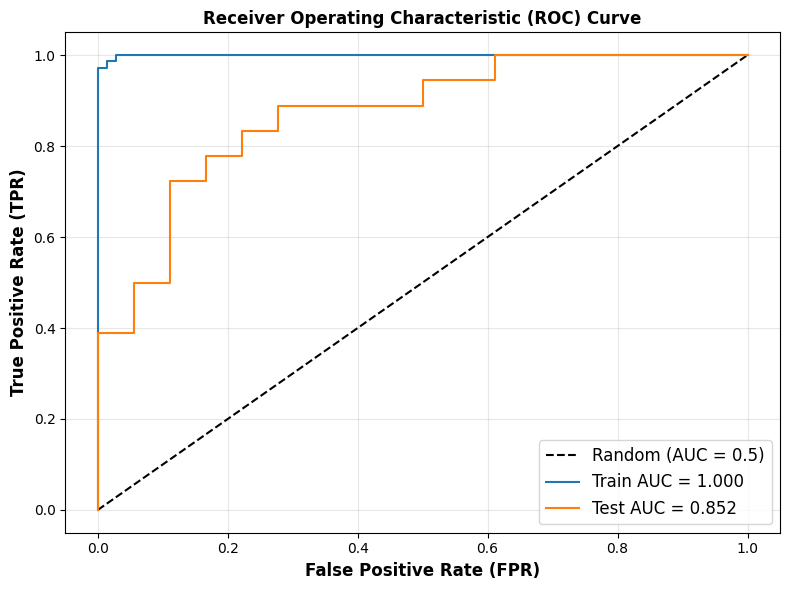

epoch/accuracy,▂▁▃▄▂▃▄▄▄▄█▅▆▇▅▇▇█▇█▇█▇█▇█▇▇▇▇████▇▇███▇
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▇▃▃▃▅▃▃▂▄▂▂▁▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▂▂▁▂▂▅▅▆▁██▆▆▇█▇▇▆█▇▇██▆▆▇▇██▇▇▇█▆▇
epoch/val_loss,▄█▄▃▂▂▄▂▄▂▃▃▂▂▂▁▂▁▂▃▅▃▄▄▂▂▃▂▃▄▅▂▃▄▅▃▅▆▇▃
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_roc_auc,▁



[VISUALIZATIONS]


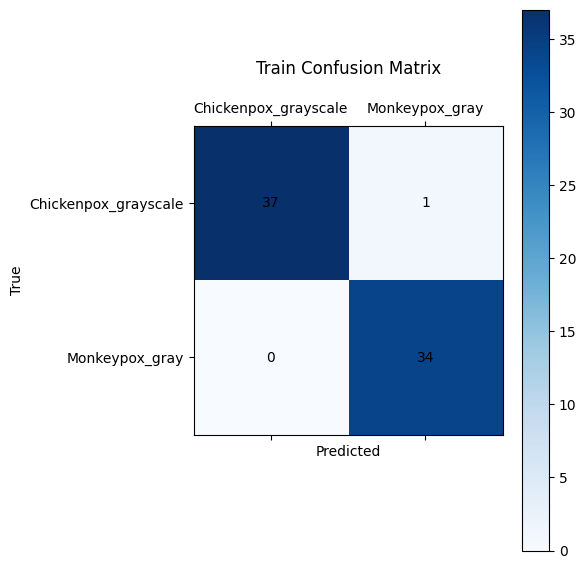

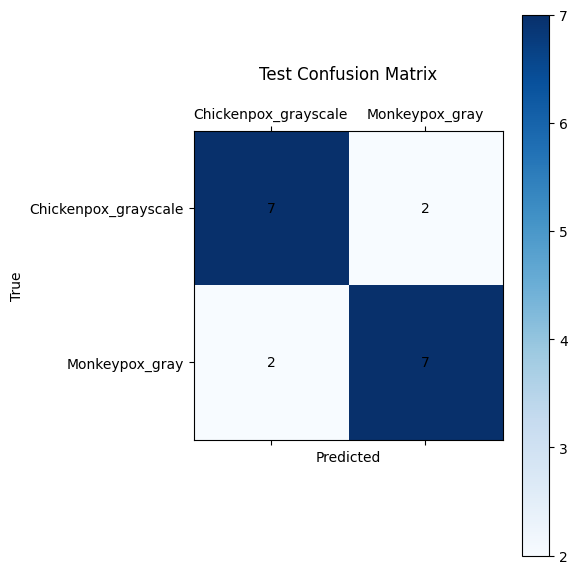

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

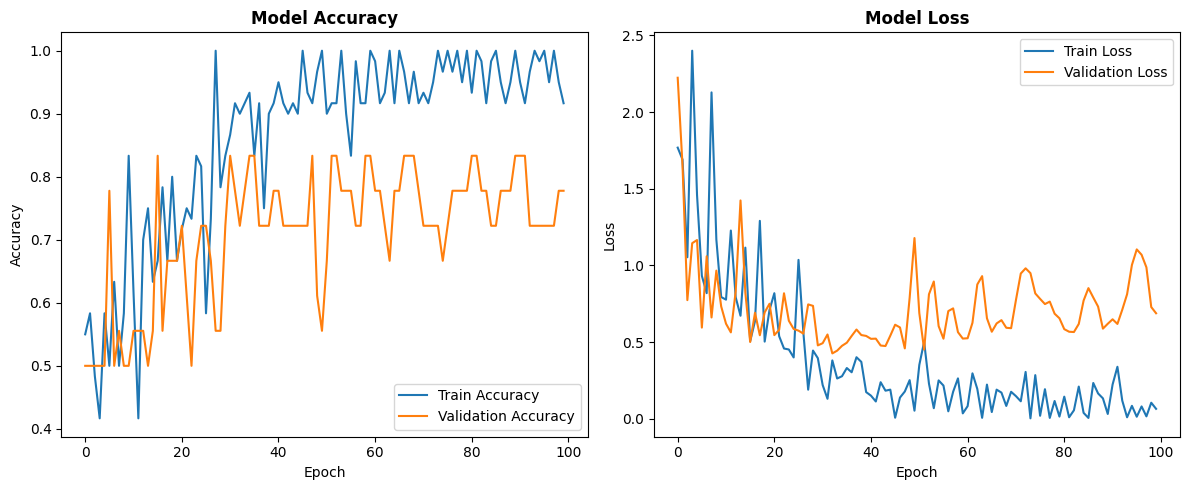

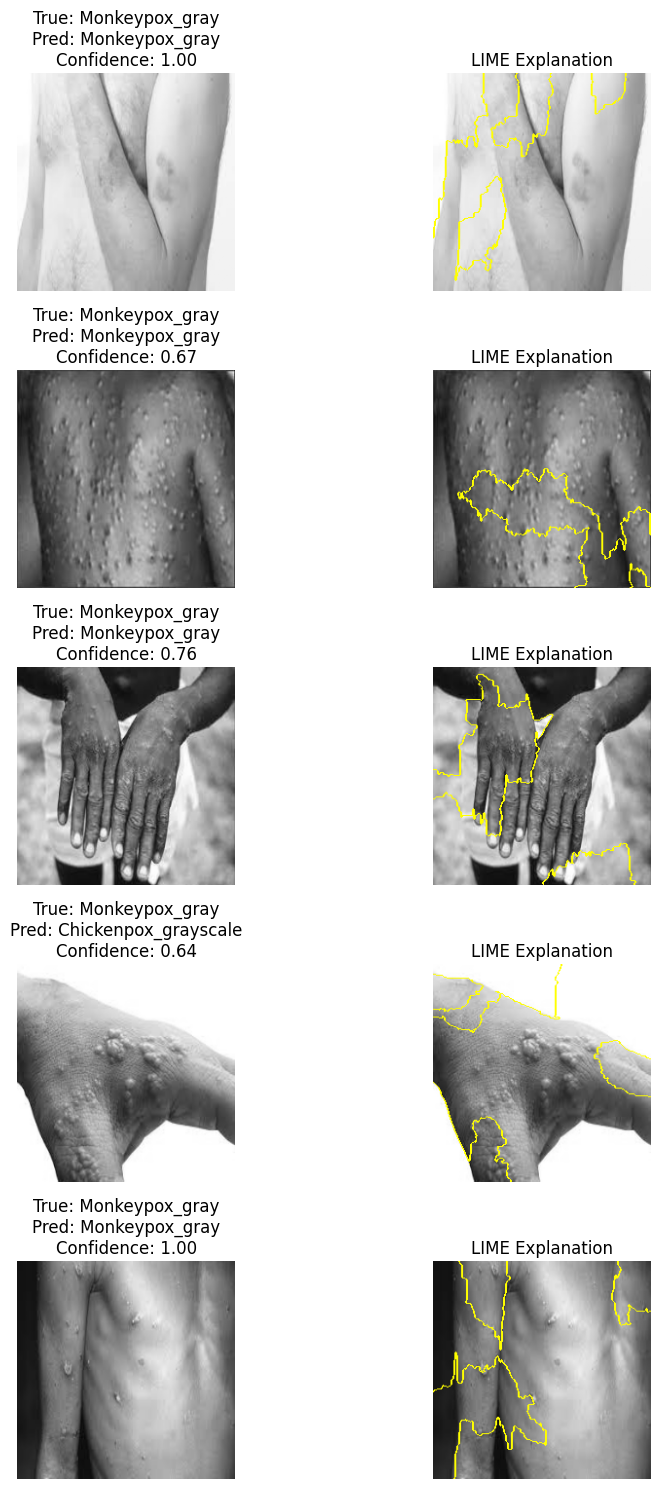

In [9]:
# =============================================
# FINAL VISUALIZATIONS
# =============================================

# Generate predictions for ROC curve
train_preds = model.predict(trainX)
test_preds = model.predict(testX)

# Calculate ROC curve metrics
fpr_train, tpr_train, _ = roc_curve(trainY.ravel(), train_preds.ravel())
fpr_test, tpr_test, _ = roc_curve(testY.ravel(), test_preds.ravel())

# Generate AUC-ROC curve visualization
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.3f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.3f}')
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.legend(loc='lower right', prop={'size': 12})
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and display the plot
roc_curve_fig = plt.gcf()
wandb.log({"AUC_ROC_curve": wandb.Image(roc_curve_fig)})
plt.show()

# Finish W&B run
wandb.finish()

# Display all figures in notebook
print("\n[VISUALIZATIONS]")
display(train_cm_fig)  # Training confusion matrix
display(test_cm_fig)   # Test confusion matrix
display(roc_fig)       # ROC curve
display(history_fig)   # Training history
display(lime_fig)      # LIME explanations